In [3]:
import numpy as np

In [ ]:
def pairwize(array):
    return np.transpose(np.stack([np.roll(np.arange(4), -i) for i in range(2)]))
def fitness(solution, distance):
    cost = 0
    pairs = pairwize(solution)
    for edge in pairs:
        cost += distance[tuple(edge)]
    return cost 

def get_travel(solution, city_points):
    travel = []
    for v in solution:
        travel.append(city_points[v])
    travel.append(city_points[solution[0]])
    return np.array(travel)

def init_tsp(NB_CITIES):
    cities = np.random.rand(NB_CITIES, 2)
    distances = np.zeros((NB_CITIES, NB_CITIES))

    for from_city, p1 in enumerate(cities):
        for to_city, p2 in enumerate(cities):
            if from_city != to_city:
                distances[from_city][to_city] = distances[to_city][from_city] = np.linalg.norm(p1-p2)
                
    np.fill_diagonal(distances, 0.000000000001)
    return cities, distances

def get_random_solution(NB_CITIES):
    solution=(list(range(NB_CITIES)))
    return np.random.shuffle(solution)

def plot_solution(solution):
    import matplotlib.pyplot as plt
    from copy import deepcopy
    x, y = zip(*get_travel(solution, deepcopy(cities)))
    plt.plot(x,y)
    x, y = zip(*cities)
    plt.scatter(x, y, marker='*') 
    
def getP(visibility, pheromones, alpha=1.0, beta=1.0):
    return np.multiply(np.power(visibility, alpha), np.power(pheromones, beta)) / \
        np.sum(np.multiply(np.power(visibility, alpha), np.power(pheromones, beta)))

    #return np.multiply(np.power(visibility, alpha), np.power(pheromones, beta)) / \
    #        np.sum(np.multiply(np.power(visibility, alpha), np.power(pheromones, beta)), axis=1)

def P_i(i, tabu, visibility, pheromones, alpha=1.0, beta=1.0):
    if len(visibility[i][tabu]) == 1:
        return [1.0]
    return getP(visibility[i][tabu], pheromones[i][tabu])

def select(P, i):
    if(len(P) == 1):
        return 0
    return np.random.choice(np.arange(len(P)), p=P)



[3. 4. 0. 8. 6. 1. 7. 9. 5. 2.]
[3. 0. 8. 9. 7. 6. 1. 4. 2. 5.]
[0. 5. 6. 2. 7. 9. 8. 1. 4. 3.]
[7. 9. 2. 8. 0. 3. 6. 4. 5. 1.]
[4. 3. 7. 9. 8. 1. 6. 5. 0. 2.]
[1. 7. 3. 9. 4. 8. 0. 5. 6. 2.]
[1. 8. 6. 2. 9. 7. 0. 3. 4. 5.]
[2. 3. 8. 9. 5. 7. 6. 1. 0. 4.]
[2. 8. 4. 1. 9. 6. 5. 0. 7. 3.]
[4. 5. 7. 0. 6. 1. 3. 9. 8. 2.]
2.044941876372364
[8. 9. 6. 7. 5. 2. 1. 3. 4. 0.]
[5. 1. 9. 0. 4. 8. 2. 3. 7. 6.]
[7. 4. 2. 0. 5. 1. 3. 8. 9. 6.]
[4. 5. 9. 1. 6. 7. 8. 0. 3. 2.]
[2. 9. 1. 7. 6. 8. 3. 4. 0. 5.]
[0. 9. 2. 8. 1. 7. 3. 4. 6. 5.]
[2. 9. 7. 5. 0. 6. 1. 4. 8. 3.]
[4. 6. 9. 3. 8. 2. 7. 0. 1. 5.]
[3. 7. 5. 6. 0. 4. 9. 2. 8. 1.]
[3. 8. 4. 9. 5. 7. 1. 6. 0. 2.]
2.044941876372364
[9. 8. 2. 1. 0. 4. 7. 6. 5. 3.]
[2. 1. 0. 3. 4. 6. 8. 9. 7. 5.]
[4. 7. 0. 5. 1. 3. 9. 2. 6. 8.]
[1. 6. 2. 5. 9. 7. 0. 4. 3. 8.]
[6. 4. 0. 1. 9. 3. 2. 7. 8. 5.]
[6. 7. 0. 9. 4. 2. 5. 8. 1. 3.]
[3. 6. 9. 2. 8. 4. 7. 0. 5. 1.]
[9. 4. 3. 7. 2. 8. 0. 6. 5. 1.]
[4. 8. 0. 7. 6. 2. 9. 5. 3. 1.]
[2. 1. 9. 0. 4. 7. 6. 8. 3. 5.]
2.04

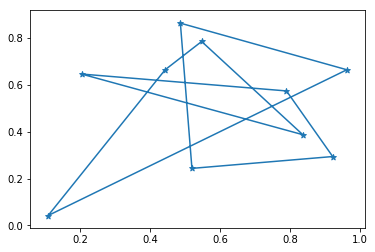

In [398]:
NB_CITIES=10
NB_ANTS  =10
NB_ITER  =10
cities, distances = init_tsp(NB_CITIES)
visibility = 1 / distances
np.fill_diagonal(visibility, 0)
pheromones = np.ones_like(visibility)
evaporation = 0.85
Q = 1.5
L = np.zeros(NB_ANTS)
for iteration in range(NB_ITER):
    solutions = np.zeros((NB_ANTS, NB_CITIES))
    tabus     = np.ones((NB_ANTS, NB_CITIES), dtype=bool)
    ids       = np.arange(NB_CITIES)
    for ant in range(NB_ANTS):
        s = np.random.randint(NB_CITIES)
        solutions[ant, 0] = s
        tabus[ant, s] = False
        for i in range(1, NB_CITIES):
            p = P_i(s, tabus[ant], visibility, pheromones)
            s = select(p, s)
            solutions[ant, i] = ids[tabus[ant]][s]
            tabus[ant, ids[tabus[ant]][s]] = False
        L[ant] = fitness(solutions[ant].astype(int), distances)
        print(solutions[ant])
    pheromones = evaporation * pheromones
    for ant in range(NB_ANTS):
        for edge in pairwize(solutions[ant]):
            pheromones[edge] += Q/L[ant]
    fitnesses = np.apply_along_axis(fitness, axis=1, arr=solutions.astype(int), distance=distances)
    best = np.argmin(fitnesses)
    print(fitnesses[best])
    if iteration == NB_ITER-1:
        plot_solution(solutions[best].astype(int))

TypeError: object of type 'numpy.int64' has no len()

In [378]:
r,c=zip(*pairwize(np.arange(2)))
print(np.ix_(r,c))


(array([[0],
       [1],
       [2],
       [3]]), array([[1, 2, 3, 0]]))



In [376]:
distances[pairwize(np.arange(4))]

array([[[1.00000000e-12, 1.22051754e-01, 4.24873214e-01, 8.17084951e-01,
         6.40116274e-01, 4.82134518e-01, 7.67085789e-01, 4.85805484e-01,
         6.41902029e-01, 2.57196703e-01],
        [1.22051754e-01, 1.00000000e-12, 3.13988568e-01, 8.75536831e-01,
         6.50114849e-01, 4.53705160e-01, 7.45167622e-01, 6.03629913e-01,
         7.14990641e-01, 3.76095092e-01]],

       [[1.22051754e-01, 1.00000000e-12, 3.13988568e-01, 8.75536831e-01,
         6.50114849e-01, 4.53705160e-01, 7.45167622e-01, 6.03629913e-01,
         7.14990641e-01, 3.76095092e-01],
        [4.24873214e-01, 3.13988568e-01, 1.00000000e-12, 9.46373369e-01,
         6.23597108e-01, 3.75114204e-01, 6.22124752e-01, 8.61551587e-01,
         8.37652644e-01, 6.49304043e-01]],

       [[4.24873214e-01, 3.13988568e-01, 1.00000000e-12, 9.46373369e-01,
         6.23597108e-01, 3.75114204e-01, 6.22124752e-01, 8.61551587e-01,
         8.37652644e-01, 6.49304043e-01],
        [8.17084951e-01, 8.75536831e-01, 9.46373369e-01,

In [390]:
distances[tuple([0,1])]

0.383428545402725